- Data used here can be collected from this website : https://www.msit.go.kr/web/msipContents/contents.do?mId=OTg3

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter(action='ignore')
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 15})

# Data Preprocessing

In [4]:
data = pd.read_excel("traffic_data.xlsx", header=1)
for i in range(data.shape[0]):
    data['기간'][i] = data['기간'][i].split('.')[0] + '-'+data['기간'][i].split('.')[1]
    
data['기간'] = pd.to_datetime(data.기간)
data.set_index('기간', inplace=True)

- Augmented Dickey Fuler test를 통해 시게열 데이터가 정상성 가정을 만족시키지 못함을 확인

In [5]:
result = adfuller(data['4G'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.646551
p-value: 0.860113


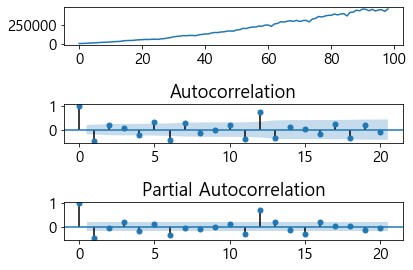

In [6]:
fig, axes = plt.subplots(3,1)
axes[0].plot(data['4G'].values)
plot_acf(data['4G'].diff().dropna(), ax=axes[1]);
plot_pacf(data['4G'].diff().dropna(), ax=axes[2])
plt.tight_layout()

- 시계열 데이터에 1차 차분을 적용

In [7]:
y = data['4G'].diff().dropna()
y_train = y[:68]
y_val = y[68:]

# 모델 적합

In [8]:
selected_model1 = SARIMAX(endog = y_train,
                                order = (0,2,2),
                                seasonal_order = (1,2,2,12))

selected_results1 = selected_model1.fit()

In [9]:
selected_results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                 4G   No. Observations:                   68
Model:             SARIMAX(0, 2, 2)x(1, 2, 2, 12)   Log Likelihood                -422.466
Date:                            Tue, 07 Jul 2020   AIC                            856.931
Time:                                    15:26:36   BIC                            867.357
Sample:                                02-01-2012   HQIC                           860.753
                                     - 09-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9750      0.902     -2.190      0.029      -3.742      -0.208
ma.L2          0.9753      0.875      1.115      0.265      -0.740       2.690
ar.S.L12       0.0362      0.981      0.037      0.971      -1.887       1.959
ma.S.L12      -1.1472      1.540     -0.745      0.456      -4.165       1.871
ma.S.L24       0.7131      1.605      0.444      0.657      -2.432       3.858
sigma2      2.235e+07   7.82e-08   2.86e+14      0.000    2.23e+07    2.23e+07
===================================================================================
Ljung-Box (Q):                       34.20   Jarque-Bera (JB):                 8.92
Prob(Q):                              0.73   Prob(JB):                         0.01
Heteroskedasticity (H):               4.92   Skew:                             0.13
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.89e+30. Standard errors may be unstable.
"""

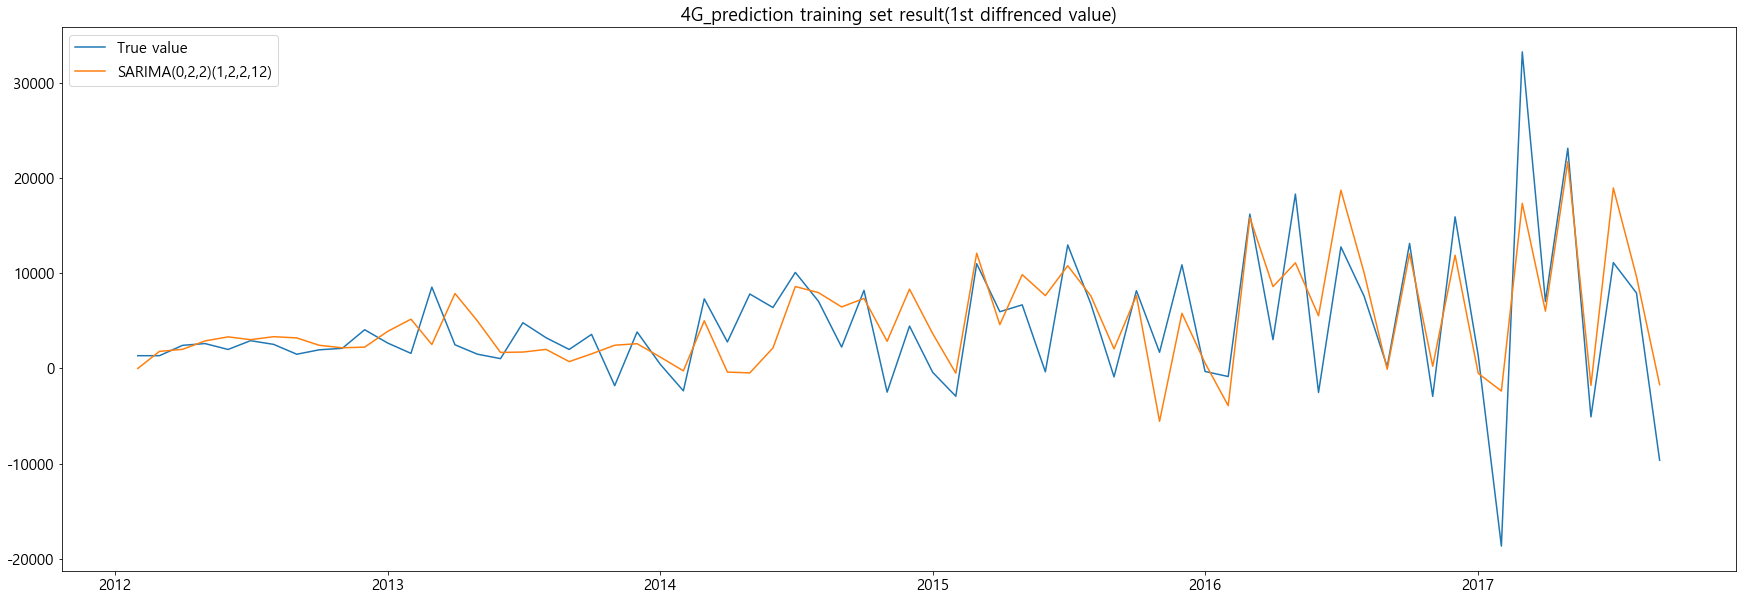

In [10]:
fig = plt.figure(figsize=(30,10))

plt.title('4G_prediction training set result(1st diffrenced value)')
plt.plot(y_train, label = 'True value')
plt.plot(selected_results1.predict(), label = 'SARIMA(0,2,2)(1,2,2,12)')


plt.legend()
plt.show()

# Validation

- 잔차가 정규성 가정, 독립성 가정을 만족시키는지를 확인

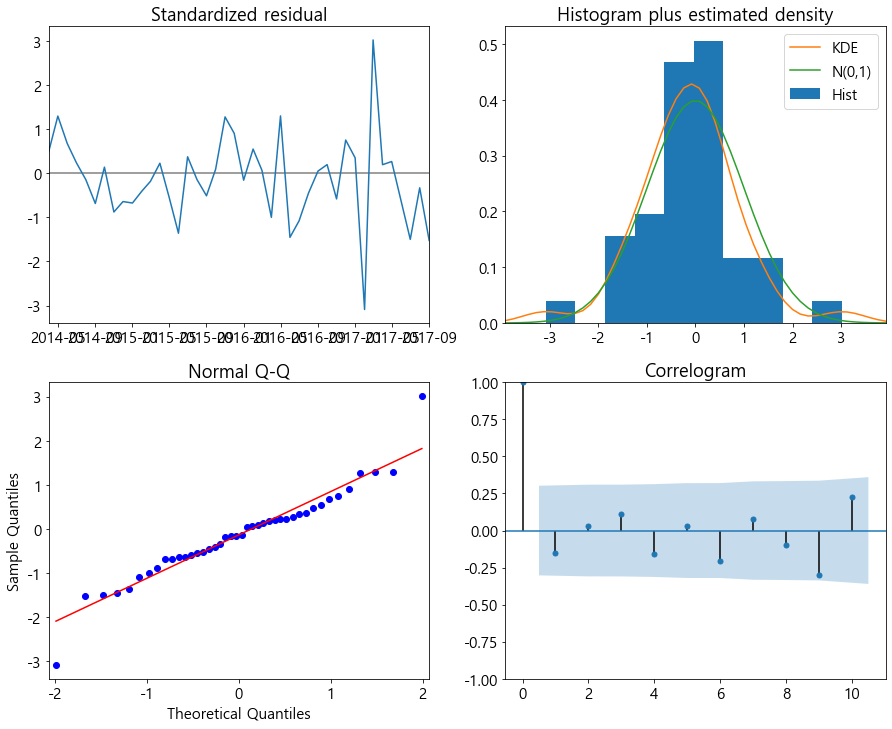

In [11]:
selected_results1.plot_diagnostics(figsize=(15, 12))
plt.show()

- 앞에서 1차 차분한 걸 돌려주기 위한 과정

In [76]:
y_pred = selected_results1.predict(start='2017-10-01', end = '2020-03-01')
y_pred.index = pd.date_range(start='2017-09-01', end='2020-02-01', freq='MS')
pred_index = pd.date_range(start='2017-09-01', end='2020-03-01', freq='MS').astype(str)

In [77]:
pred_df_4g = data['4G'].copy()

for i in range(y_pred.shape[0]):
    
        pred_df_4g.loc[pred_index[i+1]] = pred_df_4g.loc[pred_index[i]]+ y_pred[pred_index[i]]
        
final_pred = pred_df_4g.loc['2017-10-01':]

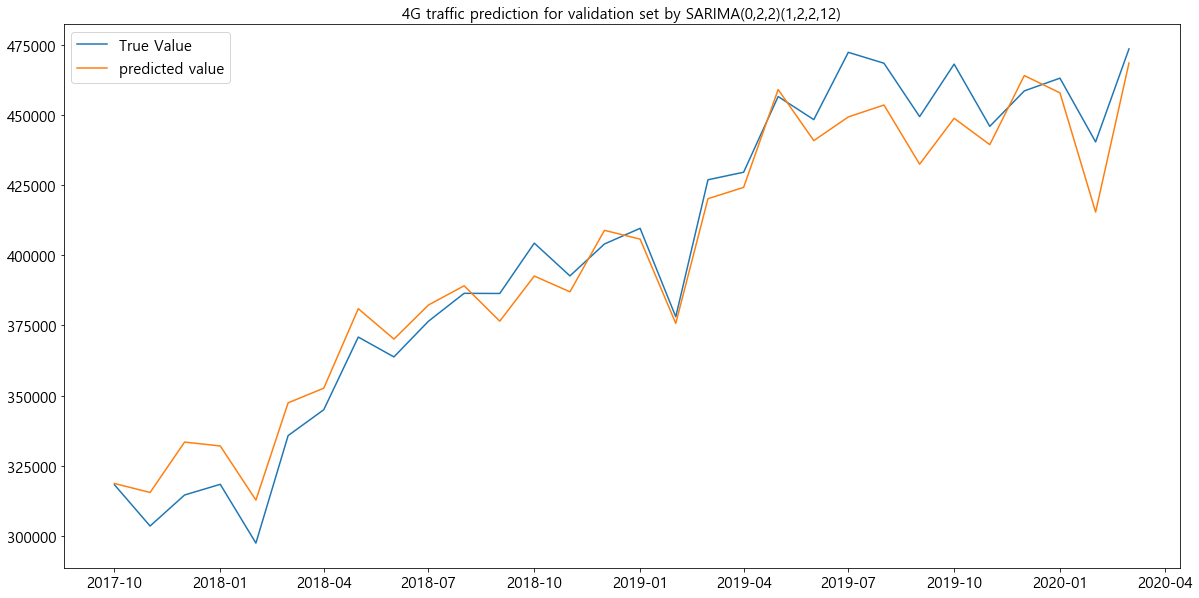

In [78]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(data.loc['2017-10-01':]['4G'], label='True Value')
ax.plot(final_pred, label='predicted value')
plt.legend(prop={'size': 15})
ax.set_title('4G traffic prediction for validation set by SARIMA(0,2,2)(1,2,2,12)', fontsize=15);

In [79]:
val_rmse = (((data.loc['2017-10-01':]['4G'] - final_pred)**2).sum()/(final_pred.shape[0]))**(1/2)
error_rate = abs((final_pred - data.loc['2017-10-01':]['4G']) / data.loc['2017-10-01':]['4G'])*100

print('training set : 20120101 ~ 20170901 (monthly, 68 observations)')
print('validation set : 20171001 ~ 20200301 (monthly, 30 observations)')
print('validation RMSE : ',val_rmse,'\n\n' )
print(pd.concat([data.loc['2017-10-01':]['4G'], final_pred.rename('4G_predcited'), error_rate.rename('4G(error rate %)')], axis=1))


training set : 20120101 ~ 20170901 (monthly, 68 observations)
validation set : 20171001 ~ 20200301 (monthly, 30 observations)
validation RMSE :  11414.118460854052 


                4G   4G_predcited  4G(error rate %)
기간                                                 
2017-10-01  318229  318673.050192          0.139538
2017-11-01  303508  315461.712687          3.938517
2017-12-01  314570  333425.377467          5.994016
2018-01-01  318373  332040.125276          4.292803
2018-02-01  297428  312755.373492          5.153306
2018-03-01  335735  347410.529071          3.477603
2018-04-01  344960  352632.180749          2.224078
2018-05-01  370850  380964.283287          2.727325
2018-06-01  363783  370133.484591          1.745679
2018-07-01  376491  382273.821095          1.535979
2018-08-01  386436  389120.740484          0.694744
2018-09-01  386387  376514.737888          2.555019
2018-10-01  404324  392597.778670          2.900204
2018-11-01  392649  386976.331749          1.444717
2

# 4G 트래픽(TB) 예측
- 예측 기간 : 2020-04 ~ 2020-12
- 위에 진행한 것과 동일한 과정을 training set뿐만 아니라 validation set까지 포함해서 학습 후 예측

In [17]:
selected_model2 = SARIMAX(endog = y,
                                order = (0,2,2),
                                seasonal_order = (1,2,2,12))

selected_results2 = selected_model2.fit()

In [18]:
selected_results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                 4G   No. Observations:                   98
Model:             SARIMAX(0, 2, 2)x(1, 2, 2, 12)   Log Likelihood                -733.487
Date:                            Tue, 07 Jul 2020   AIC                           1478.973
Time:                                    15:33:55   BIC                           1492.633
Sample:                                02-01-2012   HQIC                          1484.411
                                     - 03-01-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9910      1.264     -1.575      0.115      -4.469       0.487
ma.L2          0.9988      1.263      0.791      0.429      -1.476       3.474
ar.S.L12      -0.9174      0.218     -4.201      0.000      -1.345      -0.489
ma.S.L12      -0.4265      1.395     -0.306      0.760      -3.161       2.308
ma.S.L24      -0.5453      0.744     -0.733      0.464      -2.004       0.913
sigma2      3.009e+07   7.16e-08    4.2e+14      0.000    3.01e+07    3.01e+07
===================================================================================
Ljung-Box (Q):                       32.90   Jarque-Bera (JB):                 5.31
Prob(Q):                              0.78   Prob(JB):                         0.07
Heteroskedasticity (H):               4.58   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.81e+30. Standard errors may be unstable.
"""

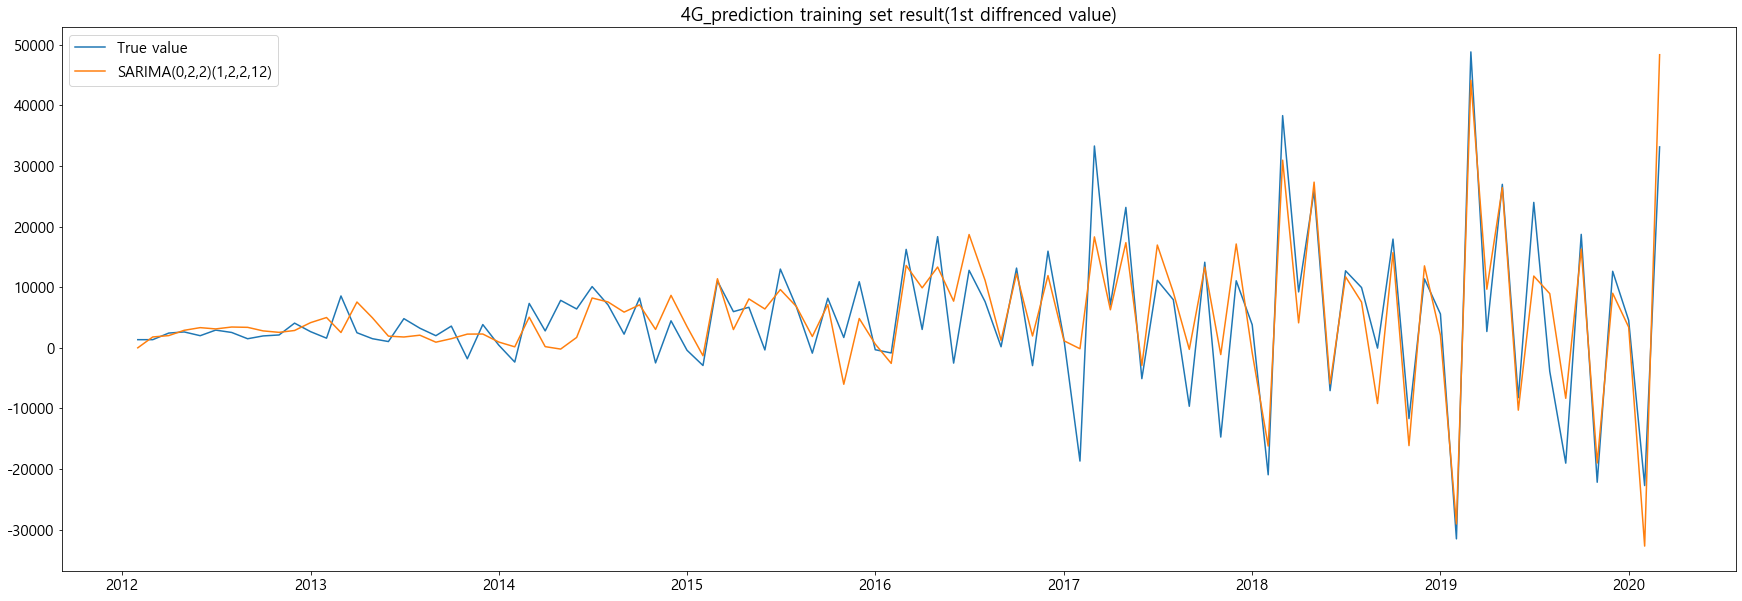

In [19]:
fig = plt.figure(figsize=(30,10))

plt.title('4G_prediction training set result(1st diffrenced value)')
plt.plot(y, label = 'True value')
plt.plot(selected_results2.predict(), label = 'SARIMA(0,2,2)(1,2,2,12)')


plt.legend()
plt.show()

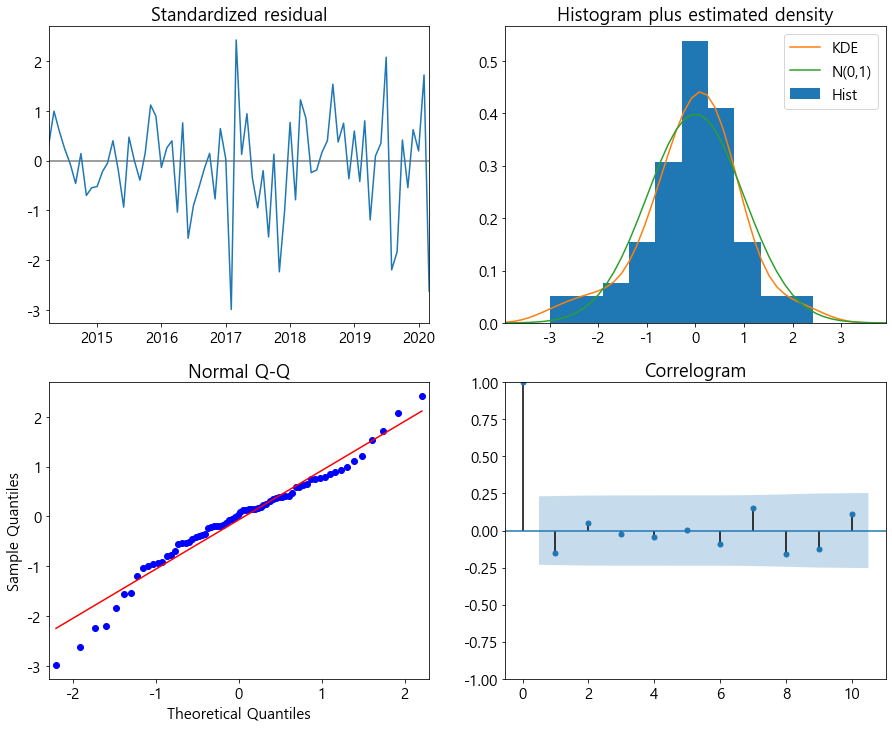

In [21]:
selected_results2.plot_diagnostics(figsize=(15, 12))
plt.show()

In [22]:
y_pred2 = selected_results2.predict(start='2020-04-01', end = '2020-12-01')
y_pred2.index = pd.date_range(start='2020-03-01', end='2020-11-01', freq='MS')
pred_index2 = pd.date_range(start='2020-03-01', end='2020-12-01', freq='MS').astype(str)

In [57]:
pred2_df_4g = data['4G'].copy()

for i in range(y_pred2.shape[0]):

        pred2_df_4g.loc[pred_index2[i+1]] = pred2_df_4g.loc[pred_index2[i]]+ y_pred2[pred_index2[i]]
        
final_pred2 = pred2_df_4g.loc['2020-04-01':]
final_pred2.index = pd.to_datetime(final_pred2.index)

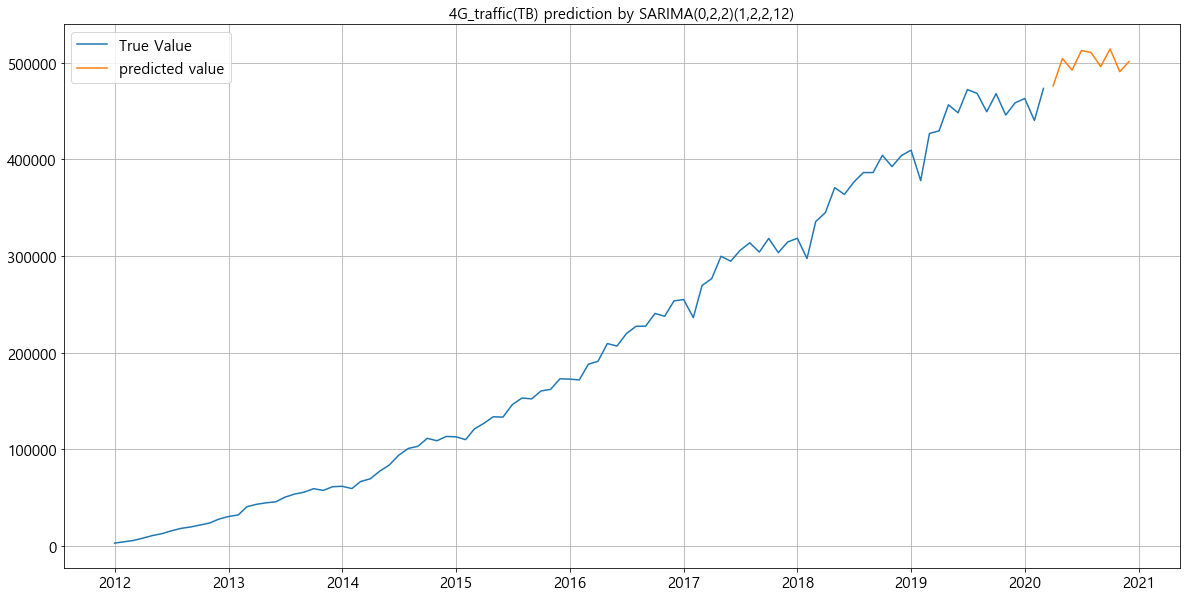

In [61]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(data.loc[:'2020-03-01']['4G'], label='True Value')
ax.plot(final_pred2, label='predicted value')
plt.legend(prop={'size': 15})
plt.grid()
ax.set_title('4G_traffic(TB) prediction by SARIMA(0,2,2)(1,2,2,12)', fontsize=15);

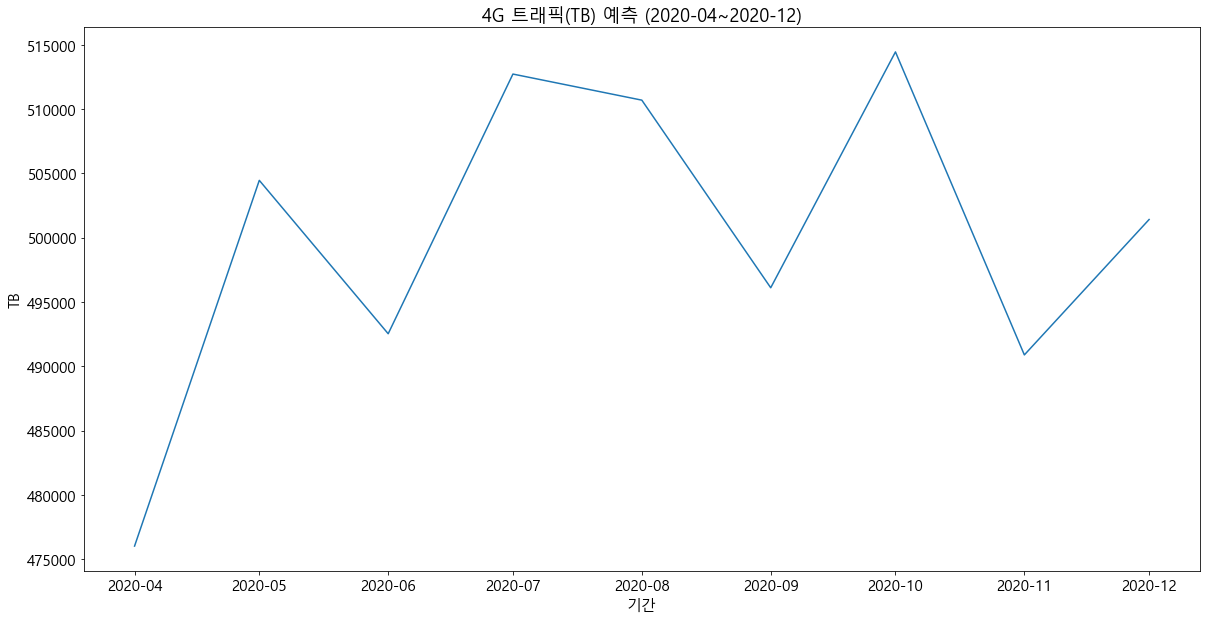

In [63]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(final_pred2)
ax.set_title('4G 트래픽(TB) 예측 (2020-04~2020-12)')
ax.set_xlabel('기간')
ax.set_ylabel('TB')
plt.show()

In [73]:
print('4G 트래픽(TB) 예측값(2020-04 ~ 2020-12)\n')
print(final_pred2.rename('4G_predicted'))

4G 트래픽(TB) 예측값(2020-04 ~ 2020-12)

기간
2020-04-01    476018.841309
2020-05-01    504458.111083
2020-06-01    492530.182038
2020-07-01    512722.613131
2020-08-01    510694.318762
2020-09-01    496105.851616
2020-10-01    514445.409013
2020-11-01    490885.308119
2020-12-01    501413.223686
Name: 4G_predicted, dtype: float64


---